In [17]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
from xgcm import Grid
import fsspec
fs = fsspec.filesystem(
    "s3",
    profile="emulator",  ## This is the profile name you configured above.
    client_kwargs={"endpoint_url": "https://nyu1.osn.mghpcc.org"},
)

In [32]:
def open_ocean_dataset(ocean_dataset_nc_files, ocean_dataset_monthly_layer_thickness_files, ocean_layer_thickness, nc_grid_path):
    with fs.open(ocean_dataset_nc_files) as f:
        ds = xr.open_dataset(f).load()
    with fs.open(ocean_dataset_monthly_layer_thickness_files) as f:
        ds_monthly_thickness = xr.open_dataset(f).load()
    upsampled = ds_monthly_thickness.interp(
        Time=ds.Time.values, method="nearest", kwargs={"fill_value": "extrapolate"}
    )
    ds["layer_thickness"] = upsampled[ocean_layer_thickness]
    with fs.open(nc_grid_path) as f:
        mesh = xr.open_dataset(f).load()
    ds["refBottomDepth"] = mesh.refBottomDepth
    wetmask = np.isnan(mesh.temperature.isel(Time=0))
    ds["wetmask"] = wetmask
    ds.wetmask.attrs["long_name"] = "wet mask"
    ds.wetmask.attrs["units"] = ""
    return ds

In [26]:
def compute_vertical_coarsening(ds: xr.Dataset, ocean_vertical_target_interface_levels, variable_names, vertical_dim="nVertLevels") -> xr.Dataset:
    target_vertical_levels = np.array(ocean_vertical_target_interface_levels)
    lev = ds.refBottomDepth
    lev_outer = np.zeros(len(lev))
    lev_outer[0] = lev.values[0] * 0.5
    lev_outer[1:] = 0.5 * (lev.values[0:-1] + lev.values[1:])
    lev_outer = np.append(lev_outer, lev.values[-1] * 2.0 - lev_outer[-1])
    ds = ds.rename_dims({vertical_dim: "lev"})
    ds = ds.assign_coords({"lev": lev, "lev_outer": lev_outer})
    grid = Grid(
        ds,
        coords={"Z": {"center": "lev", "outer": "lev_outer"}},
        boundary="fill",
        periodic=False,
        autoparse_metadata=False,
    )
    dz = ds["layer_thickness"]
    ds_extensive = ds[variable_names] * dz
    ds_extensive = ds_extensive.assign_coords({"lev_outer": lev_outer})
    ds_extensive_regridded = xr.Dataset()
    for var in variable_names:
        ds_extensive_regridded[var] = grid.transform(
            ds_extensive[var],
            "Z",
            target_vertical_levels,
            target_data=ds.lev_outer,
            method="conservative",
        )
    ds_extensive_regridded = ds_extensive_regridded.rename({"lev_outer": "lev"})
    dz_regridded = xr.DataArray(
        np.diff(target_vertical_levels),
        dims=["lev"],
        coords={"lev": ds_extensive_regridded.lev},
    )
    ds_regridded = ds_extensive_regridded / dz_regridded
    ds_regridded = ds_regridded.assign_coords(dz=dz_regridded)
    for co_name, co in ds.coords.items():
        if "lev" not in co.dims:
            ds_regridded = ds_regridded.assign_coords({co_name: co})
    ds_regridded = ds_regridded.drop_vars("lev_outer")
    ds_regridded = ds_regridded.drop_vars("lev").rename_dims(
        {"lev": vertical_dim}
    )
    ds_regridded = ds_regridded.drop_vars("dz")
    return ds_regridded

In [ ]:
nc_grid_path = "s3://emulators/ai2_colab/2024-11-18-e3sm-vertical-coarsening-debug/mpaso.IcoswISC30E3r5.regrid.nc" 
vertical_dim = "nVertLevels"
ocean_layer_thickness = "timeMonthly_avg_layerThickness"
ocean_dataset_nc_files = "s3://emulators/ai2_colab/2024-11-18-e3sm-vertical-coarsening-debug/v3.LR.piControl_bonus.mpaso.hist.am.timeSeriesStatsCustom.0480-01-01.nc"
ocean_dataset_monthly_layer_thickness_files = "s3://emulators/ai2_colab/2024-11-18-e3sm-vertical-coarsening-debug/v3.LR.piControl_bonus.mpaso.hist.am.timeSeriesStatsMonthly.0480-01-01.nc"

In [28]:
target_levels = np.array([5.00e+00,  1.50e+01,  3.00e+01,  4.00e+01,  6.50e+01,  1.05e+02,
        1.65e+02,  2.50e+02,  3.75e+02,  5.50e+02,  7.75e+02,  1.05e+03,
        1.40e+03,  1.85e+03,  2.40e+03,  3.10e+03,  3.50e+03,  4.00e+03,
        4.70e+03,  5.40e+03])

In [33]:
ds = open_ocean_dataset(ocean_dataset_nc_files, ocean_dataset_monthly_layer_thickness_files, ocean_layer_thickness, nc_grid_path)

In [37]:
# this point has the wrong vertical coarsening profile
lat_index = 21
lon_index = 150

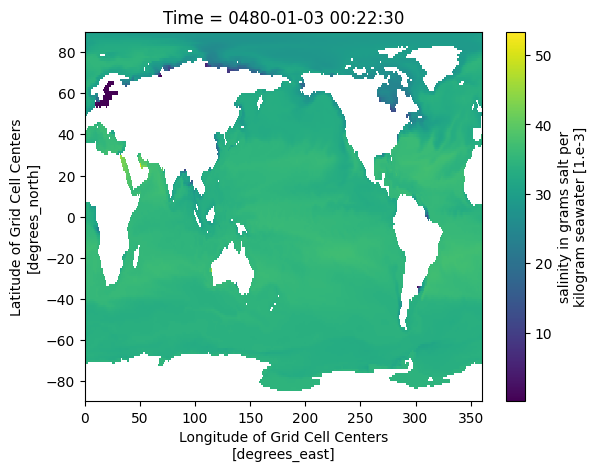

In [34]:
ds.isel(Time=0, nVertLevels=0).timeCustom_avg_activeTracers_salinity.plot()

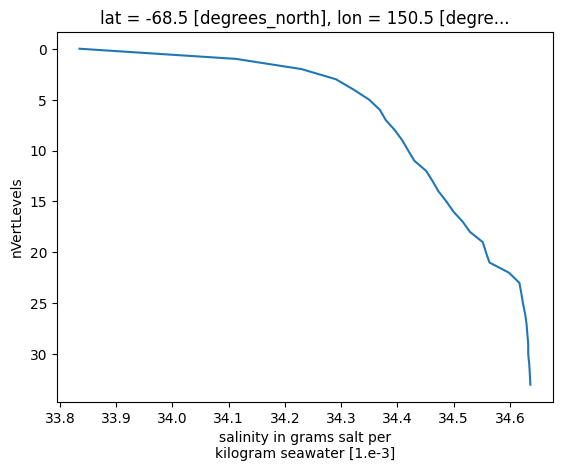

In [38]:
ds.isel(Time=0, lat=lat_index, lon=lon_index).timeCustom_avg_activeTracers_salinity.plot(y="nVertLevels", yincrease=False)

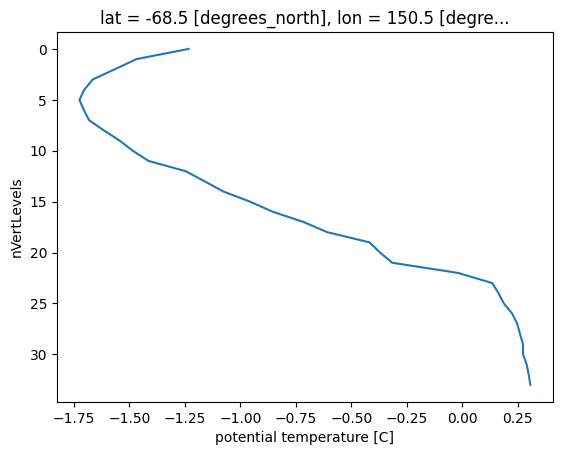

In [39]:
ds.isel(Time=0, lat=lat_index, lon=lon_index).timeCustom_avg_activeTracers_temperature.plot(y="nVertLevels", yincrease=False)

In [40]:
ds_vertical_coarsened = compute_vertical_coarsening(ds, target_levels, ["timeCustom_avg_activeTracers_salinity", "timeCustom_avg_activeTracers_temperature"])

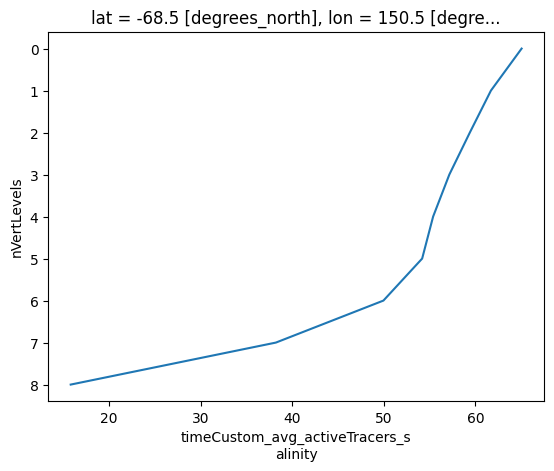

In [41]:
ds_vertical_coarsened.isel(Time=0, lat=lat_index, lon=lon_index).timeCustom_avg_activeTracers_salinity.plot(y="nVertLevels", yincrease=False)

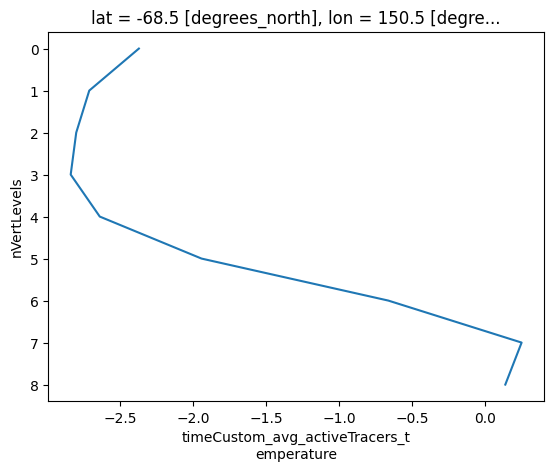

In [42]:
ds_vertical_coarsened.isel(Time=0, lat=lat_index, lon=lon_index).timeCustom_avg_activeTracers_temperature.plot(y="nVertLevels", yincrease=False)

### Linear transform instead

In [43]:
lev = ds.refBottomDepth
ds = ds.rename_dims({vertical_dim: "lev"})
ds = ds.assign_coords({"lev": lev})
grid = Grid(
        ds,
        coords={"Z": {"center": "lev"}},
        boundary="fill",
        periodic=False,
        autoparse_metadata=False,
    )
linear = grid.transform(ds.timeCustom_avg_activeTracers_salinity, 'Z', target_levels, target_data=ds.refBottomDepth)

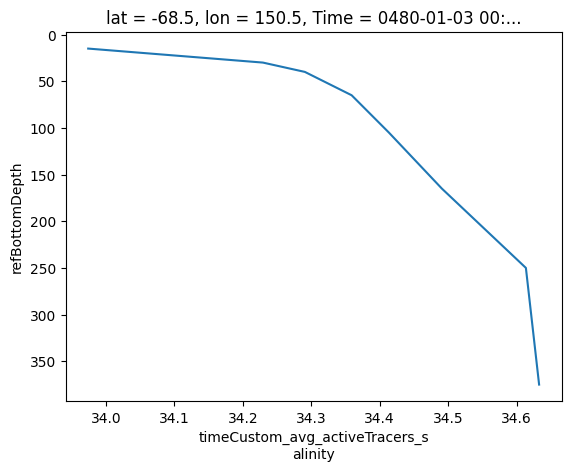

In [44]:
linear.isel(Time=0, lat=lat_index, lon=lon_index).plot(y="refBottomDepth", yincrease=False)